# Figure 1 - Compile data notebook

This notebook iterates through each paleomagnetic record (datasheet) of the vgp database, extracts data which meet user-specified criteria, and appends them to a new dataframe for later processing (to generate an APWP).

In [3]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
from tqdm import tqdm
import matplotlib.gridspec as gridspec

from vgptools.auxiliar import get_files_in_directory

from vgptools.utils_compilation import (generates_compilation, split_datasheet,
                                        recalc_vgps, go_reverse,
                                        get_alpha95, get_k,
                                        get_ages)

## Gather study files in order to generate a dataset of VGPs

We retrieve all the spreadsheet files corresponding to different studies for which site level data are compiled. 

In [4]:
current_path = os.getcwd()
data_path_VGP = current_path + '/vgp_database'
files_names = get_files_in_directory(data_path_VGP)
xlsx_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.xlsx')]
paths = [file for file in files_names if file.endswith('.xlsx')]
df_files = pd.DataFrame({'path': paths,  'name_xlsx': xlsx_file_names})

###  1. Generate an unfiltered dataset of VGPs (i.e. including sites discarded by th eoriginal authors)
In order to gather all the directions in one DataFrame `df_vgp_unfiltered` we cycle over each file and proceed to populate the VGP DataFrame following the workflow outlined in Notebook `0_Preprocessing.ipynb`. All the reported paleomagnetic poles are gathered in `df_poles_original`.

*Note: the DataFrame includes Directions/VGPs originally discarded by the authors.*

In [5]:
def merge_files(df_files):
    
    for i in tqdm(df_files.index):   # cycle over each file in database

        # import data and assign to dataframes
        df_poles_temp, df_vgps_temp = split_datasheet(df_files, i)

        df_vgps_temp['rej_crit'] = [[int(float(j)) for j in str(i.rej_crit).split(';') if ~np.isnan(float(j))] for _,i in df_vgps_temp.iterrows()]
        df_vgps_temp['Study'] = df_files.name_xlsx[i]
        df_poles_temp['Study'] = df_files.name_xlsx[i]
        # 
        if not df_vgps_temp.empty:

            df_vgps_temp = recalc_vgps(df_vgps_temp)       
            df_vgps_temp = go_reverse(df_vgps_temp)        
            df_vgps_temp = get_alpha95(df_vgps_temp)        
            df_vgps_temp = get_k(df_vgps_temp)
            df_vgps_temp = get_ages(df_vgps_temp, round_ceil = False)

            df_vgps_temp['age_uncertainty'] = df_vgps_temp['max_age'] - df_vgps_temp['min_age']

            if i == 0 : df_vgp_unfiltered = pd.DataFrame(data=None, columns=df_vgps_temp.columns); df_poles_original = pd.DataFrame(data=None, columns=df_poles_temp.columns)

            # parse data
            df_vgp_unfiltered = df_vgp_unfiltered.append(df_vgps_temp, ignore_index=True)
            df_poles_original = df_poles_original.append(df_poles_temp, ignore_index=True)
    
    return df_vgp_unfiltered, df_poles_original

In [6]:
df_vgp_unfiltered, df_poles_original = merge_files(df_files)

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:46<00:00,  1.40s/it]


###  2. Subselect VGPs that were originally taken into account to the calculation of the paleomagnetic pole.

*Note: the column `df_vgp_unfiltered['in_study_pole']` labels with `0` the VGPs that were not taken into account in the Paloemagnetic Pole. 
We can group the paleopoles within the same study with different numbers in the same column.*

In [7]:
def original_selection(df_unfiltered, df_poles_original):
    
    '''
    input: Pass an unfiltered DF 
    output: Selected entries that were considered by their authors to the calculation of PPs.
    
    Note: This is achieved taking advantage on the values in column df_unfiltered[`in_study_pole`]. Sero
    valued entries were discarder and integers labels different poles within the same study.
    '''    
    
    df_unfiltered['keep'] = np.nan    
    df_unfiltered['keep'] = df_unfiltered.apply(lambda row: True if row.in_study_pole != 0 else row.keep, axis = 1)
    df_filtered = df_unfiltered.loc[df_unfiltered['keep'] == True]
      
    # iterate through each study in order to recompute and store the paleomagnetic poles
    df_pole_compilation = pd.DataFrame(data = None, columns = df_poles_original.columns)    
    
    for study, df_study in df_filtered.groupby('Study'):
        
        # iterate through each study
        for pole, df_pole in df_study.groupby('in_study_pole'):
            
            ppole = ipmag.fisher_mean(dec = df_pole['vgp_lon_SH'].tolist(), inc = df_pole['vgp_lat_SH'].tolist()) # final paleopole
            mean_site = ipmag.fisher_mean(dec = df_study['slon'].tolist(), inc = df_study['slat'].tolist())
            
            if len(df_pole) == 1: 
                mean_site['inc'] = df_pole['slat'].values[0]; mean_site['dec'] = df_pole['slon'].values[0] 
                ppole['inc'] = df_pole['vgp_lat_SH'].values[0]; ppole['dec'] = df_pole['vgp_lon_SH'].values[0]
                ppole['n'] = df_pole['n'].values[0]; ppole['k'] = df_pole['k'].values[0]; ppole['alpha95'] = df_pole['alpha95'].values[0]
                
            
            df_pole_compilation = df_pole_compilation.append({'Study': study, 'pole': pole, 
                                                              'slat': mean_site['inc'], 'slon': mean_site['dec'],
                                                              'Plat': ppole['inc'], 'Plon': ppole['dec'],
                                                              'N': ppole['n'], 'K': ppole['k'], 'A95': ppole['alpha95'],
                                                              'min_age': df_pole.min_age.min(), 'max_age': df_pole.max_age.max(), 
                                                              'mean_age': (df_pole.max_age.max() + df_pole.min_age.min()) / 2 }, 
                                                              ignore_index = True)        
    df_pole_compilation = df_pole_compilation[['Study','pole','N','K','A95','slat','slon','Plat','Plon','min_age','max_age','mean_age']]
    return df_filtered, df_pole_compilation

In [8]:
df_filtered, df_pole_compilation = original_selection(df_vgp_unfiltered, df_poles_original)

# Study locations and VGPs by age

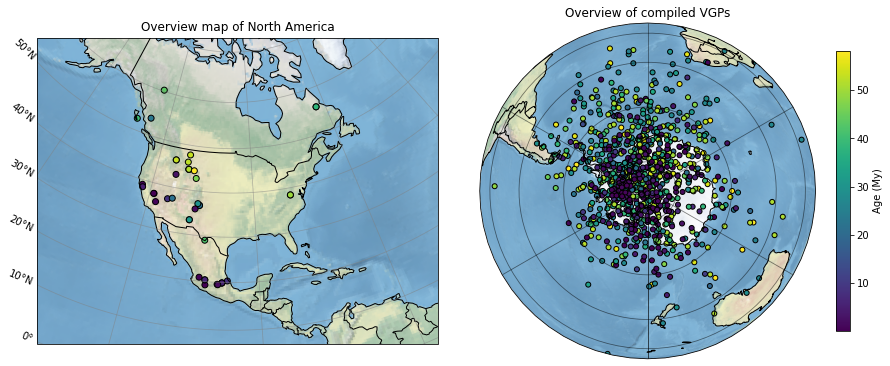

In [11]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
proj1 = ccrs.LambertConformal()

plt.figure(figsize=(12,10))

ax1 = plt.subplot(2, 2, 1, projection = proj1)
ax1.patch.set_visible(False)
ax1.set_extent([-135, -55, 5, 68], ccrs.Geodetic())
ax1.add_feature(cfeature.BORDERS)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.8, color='gray', alpha=0.5, linestyle='-')
gl.ylabels_left = True
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)
ax1.stock_img()


plt.title('Overview map of North America')
plt.scatter(
    df_pole_compilation.slon,
    df_pole_compilation.slat,
    c = df_pole_compilation.mean_age,
    edgecolors= "black", marker = "o",
    cmap="viridis",
    transform=ccrs.PlateCarree(),
)
plt.tight_layout()


ax2 = plt.subplot(2, 2, 2, projection=proj)
ax2.set_title('Overview of compiled VGPs')
ax2.add_feature(cfeature.BORDERS)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.8, color='black', alpha=0.5, linestyle='-')
gl.ylabels_left = True
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.COASTLINE)
ax2.stock_img()

plt.title('Overview of compiled VGPs')
s = plt.scatter(
    df_filtered.vgp_lon_SH,
    df_filtered.vgp_lat_SH,
    c = df_filtered.mean_age,
    edgecolors= "black", marker = "o", s = 25,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
)
plt.tight_layout()

plt.colorbar(s, fraction=0.035).set_label("Age (My)")

### Age distribution of VGPs

<AxesSubplot:title={'center':'Age distribution of compiled VGPs'}, xlabel='Mean Age', ylabel='Number of compiled VGPs'>

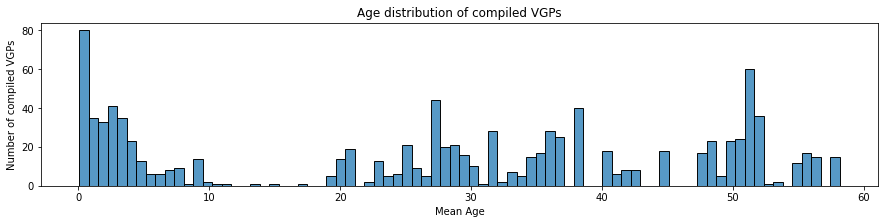

In [22]:
fig = plt.figure(figsize=(15,3))
plt.title('Age distribution of compiled VGPs')
plt.ylabel('Number of compiled VGPs')
plt.xlabel('Mean Age')
sns.histplot(data = df_filtered, x = 'mean_age', bins = 80, legend = False)
# sns.distplot(df_filtered['mean_age'], bins=100)

# Recomputed poles

In [26]:
df_pole_compilation[df_pole_compilation['pole'] == 1]

,Study,pole,N,K,A95,slat,slon,Plat,Plon,min_age,max_age,mean_age
0,Absaroka_volcanics,1,19,10.051542,11.140298,44.613899,250.051065,-83.364268,358.641493,48.0,49.0,48.5
3,Beaver_River_intrusions,1,21,44.972756,4.792312,60.238151,234.652209,-79.313242,327.669841,40.5,43.5,42.0
4,Bighorn_Basin_sediments,1,59,10.64057,5.954672,44.459816,251.809627,-81.549042,2.761738,52.54,59.237,55.8885
5,Bishop_tuff,1,47.0,127.0,1.9,37.67,241.25,-80.164116,314.290252,0.7661,0.7679,0.767
6,Bitterroot_Dome_intrusions,1,11,34.082686,7.93379,46.1908,245.543303,-72.178647,344.432968,46.4,55.5,50.95
8,Central_Mexico_Plio-Pleistocene,1,13,61.071911,5.347242,19.551706,260.39884,-88.503095,154.996894,0.0,4.51,2.255
9,Clear_Lake_volcanic_field,1,3,5.300917,59.96619,38.961941,237.332338,-84.889461,298.871431,0.84,1.37,1.105
10,Coso_Range_volcanics,1,2,16.165811,66.822315,35.944511,242.221048,-73.775957,249.302652,0.83,1.31,1.07
11,Dinan_Bay_lavas,1,13,18.744472,9.832138,53.649138,233.320816,-83.335839,324.273564,18.9,26.4,22.65
12,Eastern_Alkaline_Province,1,17,42.479588,5.536743,20.327289,262.723839,-88.340153,267.711248,1.5,14.97,8.235


41


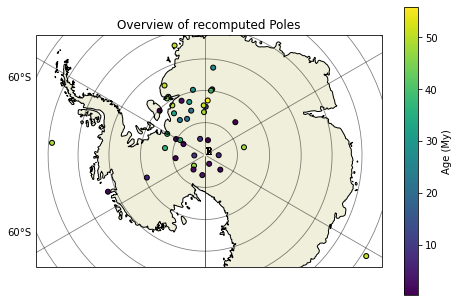

In [16]:
fig = plt.figure()

proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)

ax = fig.add_axes([0, 0, 1, 1], projection = proj)
ax.patch.set_visible(False)
#ax.set_extent([-135, -55, 5, 68], ccrs.Geodetic())
ax.set_title('Overview of recomputed Poles')
ax.add_feature(cfeature.BORDERS)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.8, color='black', alpha=0.5, linestyle='-')
gl.ylabels_left = True
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
# ax.stock_img()
# ax.set_global() 

plt.scatter(
    df_pole_compilation.Plon,
    df_pole_compilation.Plat,
    c = df_pole_compilation.mean_age,
    edgecolors= "black", marker = "o", s = 25,
    cmap="viridis",
    transform=ccrs.PlateCarree())

for i in range(df_pole_compilation.shape[0]):
    plt.annotate(df_pole_compilation.pole.tolist()[i], (df_pole_compilation.Plon.tolist()[i], df_pole_compilation.Plat.tolist()[i]), transform=ccrs.PlateCarree())

print(df_pole_compilation.shape[0])
plt.tight_layout()

plt.colorbar().set_label("Age (My)")


plt.show()

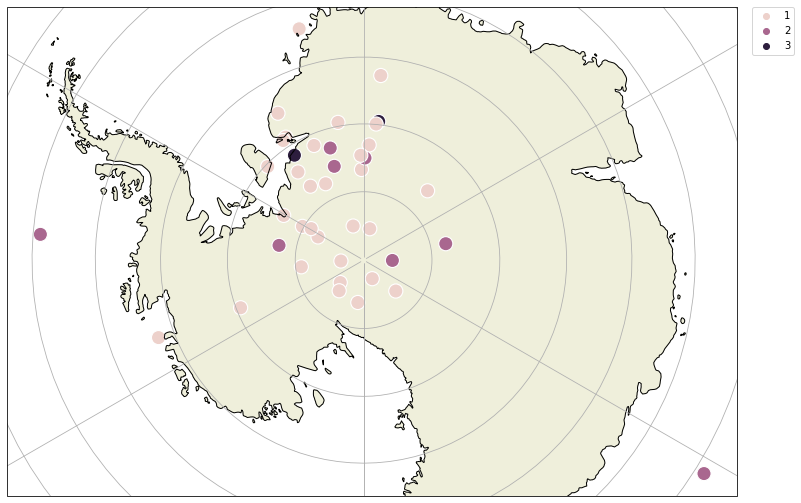

In [17]:
fig = plt.figure(figsize=(20, 9))
    
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
# ax.stock_img()
ax = plt.axes(projection=proj)    
ax.add_feature(cfeature.BORDERS)
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

p1 = sns.scatterplot(x = df_pole_compilation['Plon'], y = df_pole_compilation['Plat'], hue = df_pole_compilation['pole'], 
                 s=200, transform=ccrs.PlateCarree())

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [33]:
df_poles_original['Plat_SH'] = np.where( df_poles_original['Plat'] > 0, -df_poles_original['Plat'], df_poles_original['Plat'])
df_poles_original['Plon_SH'] = np.where( df_poles_original['Plat'] > 0,(df_poles_original['Plon'] - 180.) % 360., df_poles_original['Plon'])          

In [34]:
pole_rec = df_pole_compilation[df_pole_compilation['Study'] == 'Absaroka_volcanics']
pole_original = df_poles_original[df_poles_original['Study'] == 'Absaroka_volcanics']
pole_original

,pole,name,slat,slon,N,dec,inc,k,alpha95,f_corr,Plat,Plon,K,A95,dp,dm,mean_age,min_age,2sig_min,max_age,2sig_max,uncer_dist,rock_typ_1,rock_typ_2,rock_typ_3,R1,R2a,R2b,R3,R4,R5a,R5b,R6,R7,pmag_ref,age_ref,pmag_comments,age_comments,Study,Unnamed: 38,Plat_SH,Plon_SH
16,1.0,Absaroka volcanics pole 1,NaN,NaN,19.0,349.9,61.8,14.7,8.4,NaN,83.5,177.4,10.2,10.1,NaN,NaN,NaN,48.0,NaN,49.0,NaN,uniform,igneous,volcanic,basalt,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,Shive and Pruss (1977),Harlan and Morgan (2010);,only AF demag appears to have been used (thus ...,NaN,Absaroka_volcanics,NaN,-83.5,357.4
17,2.0,Absaroka volcanics pole 2,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,NaN,49.0,NaN,uniform,igneous,volcanic,basalt,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,Re-calculated from Nyblade et al. (1986) [who ...,Harlan and Morgan (2010),no mean direction / pole position calculated b...,crude age range provided by Harlan and Morgan ...,Absaroka_volcanics,NaN,NaN,NaN
18,3.0,Absaroka volcanics pole 3,NaN,NaN,22.0,347.6,59.2,21.8,6.8,NaN,80.8,145.9,14.0,8.6,NaN,NaN,NaN,45.0,NaN,54.0,NaN,uniform,igneous,mixed,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Harlan and Morgan (2010),Harlan and Morgan (2010); but see age_comment,AF and thermal demagnetization; rock-magnetic ...,uniform age range estimated here is just a cru...,Absaroka_volcanics,NaN,-80.8,325.9
19,1+2+3,Absaroka volcanics grand mean pole,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,83.1,146.3,13.5,6.2,NaN,NaN,NaN,45.0,NaN,54.0,NaN,uniform,igneous,mixed,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Harlan and Morgan (2010),Harlan and Morgan (2010); but see age_comment,seems to have dismissed two VGPs from the stud...,uniform age range estimated here is just a cru...,Absaroka_volcanics,Harlan and Morgan (2010); Shive and Pruss (197...,-83.1,326.3


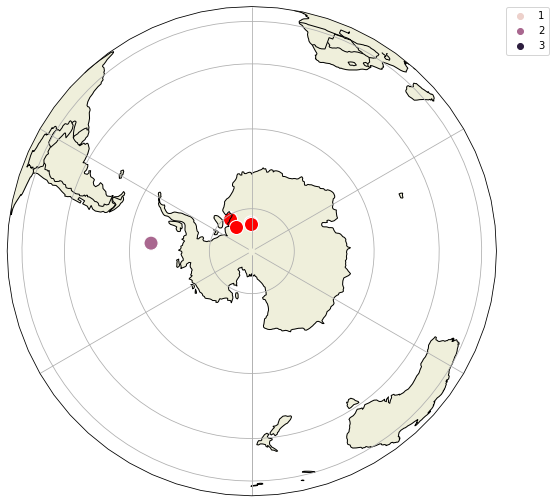

In [36]:
fig = plt.figure(figsize=(20, 9))
    
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
# ax.stock_img()
ax = plt.axes(projection=proj)    
ax.add_feature(cfeature.BORDERS)
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_global() 

sns.scatterplot(x = pole_rec['Plon'], y = pole_rec['Plat'], hue = pole_rec['pole'], 
                 s=200, transform=ccrs.PlateCarree())

sns.scatterplot(x = pole_original['Plon_SH'], y = pole_original['Plat_SH'], color = 'r',
                 s=200, transform=ccrs.PlateCarree())

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [29]:
df_pole_compilation[df_pole_compilation['pole'] == 2]
df_filtered.head(2)

,name,fm./loc.,slat,slon,n,dec,inc,k,alpha95,f_corr,VGP_lat,VGP_lon,K,A95,dp,dm,mean_age,min_age,2sig_min,max_age,2sig_max,uncer_dist,rock_typ_1,rock_typ_2,rock_typ_3,demag,struc_cont,rot_area,polarity,strat_group,ordering,synch_unit,in_study_pole,rej_crit,pmag_ref,age_ref,pmag_comments,age_comments,Unnamed: 38,Study,VGP_lon_recalc,VGP_lat_recalc,dec_reverse,inc_reverse,vgp_lat_SH,vgp_lon_SH,age_uncertainty,keep
0,6.0,Sylvan Pass,44.3478,-111.0455,5.0,343.4,64.3,58.3,8.2,NaN,78.2,-186.7,NaN,NaN,NaN,NaN,48.5,48.0,NaN,49.0,NaN,uniform,igneous,volcanic,basalt,AF,1.0,0.0,N,1.0,1.0,0.0,1,[],Shive and Pruss (1977),Harlan and Morgan (2010),NaN,crude age range provided by Harlan and Morgan ...,NaN,Absaroka_volcanics,173.300455,78.199980,-64.3,163.4,-78.199980,353.300455,1.0,True
2,8.0,Sylvan Pass,44.5500,-110.0500,5.0,121.8,-73.1,165.6,4.9,NaN,52.6,-156.7,NaN,NaN,NaN,NaN,48.5,48.0,NaN,49.0,NaN,uniform,igneous,volcanic,basalt,AF,1.0,0.0,R,1.0,3.0,0.0,1,[],Shive and Pruss (1977),Harlan and Morgan (2010),NaN,crude age range provided by Harlan and Morgan ...,NaN,Absaroka_volcanics,23.328823,-52.611427,-73.1,121.8,-52.611427,23.328823,1.0,True


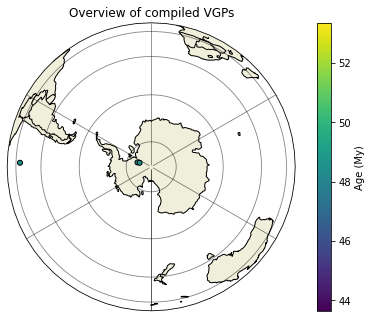

In [37]:
df_filtered_ = df_filtered[(df_filtered['in_study_pole'] == 2)&(df_filtered['Study'] == 'Absaroka_volcanics')]

fig = plt.figure()

proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)

ax = fig.add_axes([0, 0, 1, 1], projection = proj)
ax.patch.set_visible(False)
#ax.set_extent([-135, -55, 5, 68], ccrs.Geodetic())
ax.set_title('Overview of compiled VGPs')
ax.add_feature(cfeature.BORDERS)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.8, color='black', alpha=0.5, linestyle='-')
gl.ylabels_left = True
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
# ax.stock_img()
ax.set_global() 
plt.scatter(
    df_filtered_.vgp_lon_SH,
    df_filtered_.vgp_lat_SH,
    c = df_filtered_.mean_age,
    edgecolors= "black", marker = "o", s = 25,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
)

plt.colorbar().set_label("Age (My)")


plt.show()

In [38]:
df_filtered_

,name,fm./loc.,slat,slon,n,dec,inc,k,alpha95,f_corr,VGP_lat,VGP_lon,K,A95,dp,dm,mean_age,min_age,2sig_min,max_age,2sig_max,uncer_dist,rock_typ_1,rock_typ_2,rock_typ_3,demag,struc_cont,rot_area,polarity,strat_group,ordering,synch_unit,in_study_pole,rej_crit,pmag_ref,age_ref,pmag_comments,age_comments,Study,VGP_lon_recalc,VGP_lat_recalc,dec_reverse,inc_reverse,vgp_lat_SH,vgp_lon_SH,age_uncertainty,Unnamed: 38,keep
693,Lower Flow mean,Lower Flow,44.093705,-109.470235,20.0,175.5,-58.7,244.0,2.004094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.5,48.0,NaN,49.0,NaN,uniform,igneous,volcanic,basalt,TH,1.0,0.0,R,NaN,NaN,M6,2,[],Nyblade et al. (1986),Harlan and Morgan (2010),NaN,crude age range provided by Harlan and Morgan ...,Absaroka_volcanics,287.808703,-84.257954,-58.7,175.5,-84.257954,287.808703,1.0,NaN,True
721,Middle Flow mean,Middle Flow,44.13866,-109.347075,26.0,159.7,34.4,95.0,2.816953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.5,48.0,NaN,49.0,NaN,uniform,igneous,volcanic,basalt,TH,1.0,0.0,R,NaN,NaN,M7,2,[],Nyblade et al. (1986),Harlan and Morgan (2010),NaN,crude age range provided by Harlan and Morgan ...,Absaroka_volcanics,271.758635,-24.282326,-34.4,339.7,-24.282326,271.758635,1.0,NaN,True
728,Upper Flow mean,Upper Flow,44.107118,-109.501088,7.0,176.0,-59.4,266.0,3.244428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.5,48.0,NaN,49.0,NaN,uniform,igneous,volcanic,basalt,TH,1.0,0.0,R,NaN,NaN,M8,2,[12],Nyblade et al. (1986),Harlan and Morgan (2010),NaN,crude age range provided by Harlan and Morgan ...,Absaroka_volcanics,289.145433,-85.106864,-59.4,176.0,-85.106864,289.145433,1.0,NaN,True
